<a href="https://colab.research.google.com/github/fidanfatih/Fraud_Detection/blob/main/fraud_detection_phase10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Read dataset

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# from category_encoders import CountEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.feature_selection import RFECV
import lightgbm as lgb
from tqdm import tqdm_notebook
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import multiprocessing


import re
import gc
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

%matplotlib inline

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = 1000

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Memory Reduction

In [31]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
%%time

files = ['/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/test_identity.csv.zip', 
         '/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/test_transaction.csv.zip',
         '/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/train_identity.csv.zip',
         '/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/train_transaction.csv.zip',
         '/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/sample_submission.csv.zip']

def load_data(file):
    return pd.read_csv(file)

with multiprocessing.Pool() as pool:
    test_id, test_tr, train_id, train_tr, sub = pool.map(load_data, files)

In [ ]:
train = pd.merge(train_tr, train_id, on='TransactionID', how='left')
test = pd.merge(test_tr, test_id, on='TransactionID', how='left')

del test_id, test_tr, train_id, train_tr
gc.collect()

In [ ]:
# Check for column mismatches
def Diff(li1, li2):
    li1_dif = [i for i in li1 + li2 if i not in li1]
    li2_dif = [i for i in li1 + li2 if i not in li2]

    print(f"""not in list1:
{li1_dif}\n   
not in list2:
{li2_dif}""")

Diff(sorted(train.columns), sorted(test.columns))

In [ ]:
test.rename(columns=lambda x: x.replace("id-","id_") if "id-" in x else x, inplace=True)

In [ ]:
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.9]

big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

cols_to_drop = list(set(many_null_cols + many_null_cols_test + big_top_value_cols + big_top_value_cols_test + one_value_cols + one_value_cols_test))
cols_to_drop.remove('isFraud')
print('{} features are going to be dropped for being useless'.format(len(cols_to_drop)))

train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [ ]:
# for col in tqdm_notebook(train.columns): 
#     if train[col].dtype == 'object':
#         le = LabelEncoder()
#         le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
#         train[col] = le.transform(list(train[col].astype(str).values))

In [ ]:
test['isFraud'] = np.nan
df = pd.concat(train, test).reset_index().drop('index', axis=1)
del test, train
gc.collect()

In [ ]:
df = reduce_mem_usage(df)
df.to_pickle('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/train_test_dataset.pkl')
# df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/train_dataset.pkl')

### Recursive

In [22]:
# X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
# y = train.sort_values('TransactionDT')['isFraud']

# del train
# gc.collect()

# # RFECV does not support NaNs
# X.fillna(-999, inplace=True)

# params = {'num_leaves': 491,
#           'min_child_weight': 0.03454472573214212,
#           'feature_fraction': 0.3797454081646243,
#           'bagging_fraction': 0.4181193142567742,
#           'min_data_in_leaf': 106,
#           'objective': 'binary',
#           'max_depth': -1,
#           'learning_rate': 0.006883242363721497,
#           "boosting_type": "gbdt",
#           "bagging_seed": 11,
#           "metric": 'auc',
#           "verbosity": -1,
#           'reg_alpha': 0.3899927210061127,
#           'reg_lambda': 0.6485237330340494,
#           'random_state': 47
#          }

In [23]:
# from sklearn.model_selection import KFold, TimeSeriesSplit
# from sklearn.feature_selection import RFECV

# clf = lgb.LGBMClassifier(**params)
# rfe = RFECV(estimator=clf, step=10, cv=TimeSeriesSplit(n_splits=5), scoring='roc_auc', verbose=2)

In [ ]:
# rfe.fit(X, y)

In [ ]:
# print('Optimal number of features:', rfe.n_features_)

In [ ]:
# plt.figure(figsize=(14, 8))
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score")
# plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
# plt.show()

In [ ]:
# print(X.columns[rfe.ranking_ == 1].values)

In [ ]:
# print(X.columns[rfe.ranking_ != 1].values)

## FUNCTIONS

#### Description Functions

In [ ]:
def summary(df, pred=None):
    obs = df.shape[0]
    Types = df.dtypes
    Counts = df.apply(lambda x: x.count())
    Min = df.min()
    Max = df.max()
    Uniques = df.apply(lambda x: x.unique().shape[0])
    Nulls = df.apply(lambda x: x.isnull().sum())
    print('Data shape:', df.shape)

    if pred is None:
        cols = ['Types', 'Counts', 'Uniques', 'Nulls', 'Min', 'Max']
        str = pd.concat([Types, Counts, Uniques, Nulls, Min, Max], axis = 1, sort=True)

    str.columns = cols
    print('___________________________\nData Types:')
    print(str.Types.value_counts())
    print('___________________________')
    return str

In [ ]:
!pip install colorama
def column_details(regex, df=df):
  # We will focus on each column in detail
  # Uniqe Values, DTYPE, NUNIQUE, NULL_RATE
  global columns
  columns=[col for col in df.columns if re.search(regex, col)]

  from colorama import Fore, Back, Style

  print('Unique Values of the Features:\nfeature: DTYPE, NUNIQUE, NULL_RATE\n')
  for i in df[columns]:
      color = Fore.RED if df[i].dtype =='float64' else Fore.BLUE if df[i].dtype =='int64' else Fore.GREEN
      print(f'{i}: {color} {df[i].dtype}, {df[i].nunique()}, %{round(df[i].isna().sum()/len(df[i])*100,2)}\n{Style.RESET_ALL}{pd.Series(df[i].unique()).sort_values().values}\n')
      

In [ ]:
def null_values(df, rate=0):
    """a function to show null values with percentage"""
    nv=pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    return nv[nv['Percentage (%)']>rate].sort_values('Percentage (%)', ascending=False)

#### Plot Functions

In [ ]:
def labels(ax, df=df, xytext=(0, 0)):
    for bar in ax.patches: 
        ax.annotate('%{:.2f}\n{:.0f}'.format(100*bar.get_height()/len(df),bar.get_height()), (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                    size=11, xytext=xytext, 
                    textcoords='offset points')

def plot_col(col, df=df, figsize=(20,6)):

    fig, ax = plt.subplots(1,2,figsize=figsize, sharey=True)

    plt.subplot(121)
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    ax[0] = sns.countplot(x=col, data=df, hue='isFraud', 
                  order=np.sort(df[col].dropna().unique()),
                  )
    ax[0].tick_params(axis='x', rotation=90)
    labels(ax[0],df[col].dropna(),(0, 0))
    
    ax_twin = ax[0].twinx()
    # sns.set(rc={"lines.linewidth": 0.7})
    ax_twin = sns.pointplot(x=col, y='Fraud', data=tmp, color='black', legend=False, 
                  order = np.sort(df[col].dropna().unique()), 
                  linewidth=0.1)
    

    ax[0].grid()

    plt.subplot(122)
    ax[1] = sns.countplot(x=df[col].dropna(),
                  order= np.sort(df[col].dropna().unique()),
                  )
    ax[1].tick_params(axis='x', rotation=90)
    labels(ax[1],df[col].dropna())
    plt.show()


In [ ]:
def plot_cols(regex, figsize, target, df=df):
  columns=[col for col in df.columns if re.search(regex, col)]
  nrow, ncolumn = len(columns),1

  fig, ax = plt.subplots(nrow, ncolumn,figsize=figsize)

  for i,col in enumerate(columns):
      order = np.sort(df[col].dropna().unique())
      
      plt.subplot(nrow,ncolumn,i+1)
      ax[i] = sns.countplot(x=df[col], data= df, hue=target, order = order)
  #     labels(ax[i],df[col].dropna(),(0,0))
      
      tmp = pd.crosstab(df[col], df[target], normalize='index') * 100
      tmp = tmp.reset_index()
      tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
      
      ax_twin = ax[i].twinx()
  #     sns.set(rc={"lines.linewidth": 1})
      ax_twin = sns.pointplot(x=tmp[col], y=tmp['Fraud'],color='black', order = order)
      ax[i].grid();

In [ ]:
def hist_countplot(regex, figsize, nrow=10, ncolumn = 4, target='isFraud', df=df):
  plt.figure(figsize=figsize)
  columns=[col for col in df.columns if re.search(regex, col)]

  for i,col in enumerate(columns):
      plt.subplot(nrow,ncolumn,i+1)
      if df[col].dtype!='O':
          sns.histplot(x=df[col], data= df, hue=target)
      else:
          sns.countplot(x=df[col], data= df, hue=target) 

In [ ]:
def box_countplot(regex, figsize, nrow=10, ncolumn = 4, target='isFraud', df=df):
  plt.figure(figsize=figsize)

  columns=[col for col in df.columns if re.search(regex, col)]

  for i,col in enumerate(columns):
      plt.subplot(nrow,ncolumn,i+1)
      if df[col].dtype!='O':
          sns.boxplot(y=df[col], data= df, x=target)
      else:
          sns.countplot(x=df[col])

In [ ]:
def box_labels(ax, df, col1,col2):
    medians = df.groupby([col1])[col2].median().round(2)
    vertical_offset = df[col2].median() * 0.05 # offset from median for display

    for xtick in ax.get_xticks():
        ax.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
                horizontalalignment='center',size='small',color='w',weight='semibold')

#### Correlation Functions

In [ ]:
# Remove the highly collinear features from data
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
#                 print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return drops

In [ ]:
def corrank(X, threshold=0):
    import itertools
    df = pd.DataFrame([[i,j,X.corr().abs().loc[i,j]] for i,j in list(itertools.combinations(X.corr().abs(), 2))],columns=['Feature1','Feature2','corr'])    
    df = df.sort_values(by='corr',ascending=False).reset_index(drop=True)
    return df[df['corr']>threshold]

In [ ]:
import scipy.stats as sts

# References:
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
# https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

def cramers_v(x, y):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    confusion_matrix = pd.crosstab(x,y)
    chi2 = sts.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

#### Outlier Functions

In [ ]:
def outliers(s):
  # summary of the outliers
  iqr = (np.quantile(s, 0.75))-(np.quantile(s, 0.25))
  upper_bound = np.quantile(s, 0.75)+(1.5*iqr)
  lower_bound = np.quantile(s, 0.25)-(1.5*iqr)
  f = []
  for i in s:
      if i > upper_bound:
          f.append(i)
      elif i < lower_bound:
          f.append(i)
  sums = len(f)
  pros = len(f)/len(s)*100
  d = {'IQR':iqr,
        'Upper Bound':upper_bound,
      'Lower Bound':lower_bound,
      'Sum outliers': sums,'percentage outliers':pros}
  d = pd.DataFrame(d.items(),columns = ['sub','values'])
  return(d)


In [ ]:
def capping_outliers(col, whisker=1.5):
  # replace outliers with upper_bound and lower_bound values

  iqr = (np.quantile(df[col], 0.75))-(np.quantile(df[col], 0.25))
  upper_bound = np.quantile(df[col], 0.75)+(whisker*iqr)
  lower_bound = np.quantile(df[col], 0.25)-(whisker*iqr)

  df[col] = np.where(df[col] < upper_bound, 
                                upper_bound,df[col])
  df[col] = np.where(df[col] > lower_bound, 
                                lower_bound,df[col])
  plt.figure(figsize=(12,6))
  sns.boxplot(x= df[col]);
  return df[col]

In [ ]:
def replace_outliers(col, replaced_value='median',whisker=1.5):
  # replace outliers with 'median','mean','mode' or an assigned value.

  iqr = (np.quantile(df[col], 0.75))-(np.quantile(df[col], 0.25))
  upper_bound = np.quantile(df[col], 0.75)+(whisker*iqr)
  lower_bound = np.quantile(df[col], 0.25)-(whisker*iqr)
  if replaced_value=='median':
    df[col] = df[col].mask(df[col] > upper_bound, df[col].median())
    df[col] = df[col].mask(df[col] < lower_bound, df[col].median())
  elif replaced_value=='mean':
    df[col] = df[col].mask(df[col] > upper_bound, df[col].mean())
    df[col] = df[col].mask(df[col] < lower_bound, df[col].mean())
  elif replaced_value=='mode':
    df[col] = df[col].mask(df[col] > upper_bound, df[col].mode()[0])
    df[col] = df[col].mask(df[col] < lower_bound, df[col].mode()[0])
  else:
    df[col] = df[col].mask(df[col] > upper_bound, replaced_value)
    df[col] = df[col].mask(df[col] < lower_bound, replaced_value)   

  plt.figure(figsize=(12,6))
  sns.boxplot(x= df[col]);

  return df[col]

In [ ]:
def col_plot(df,col_name):
    plt.figure(figsize=(15,6))
    
    plt.subplot(141) # 1 satir x 4 sutun dan olusan ax in 1. sutununda calis
    plt.hist(df[col_name], bins = 20)
    f_sqrt=lambda x:(np.sqrt(x) if x>1 else -np.sqrt(-x) if x<-1 else x)
    f_log=lambda x:(np.log(x)+1 if x>1 else -np.log(-x)-1 if x<-1 else x)
    
    # üç sigma aralikta(verinin %99.7 sini icine almasi beklenen bolum) iki kirmizi cizgi arasinda
    plt.axvline(x=df[col_name].mean() + 3*df[col_name].std(),color='red')
    plt.axvline(x=df[col_name].mean() - 3*df[col_name].std(),color='red')
    plt.xlabel(col_name)
    plt.tight_layout
    plt.xlabel("Histogram ±3z")
    plt.ylabel(col_name)

    plt.subplot(142)
    plt.boxplot(df[col_name]) # IQR katsayisi, defaultu 1.5
    plt.xlabel("IQR=1.5")

    plt.subplot(143)
    plt.boxplot(df[col_name].apply(f_sqrt), whis = 1.5)
    plt.xlabel("ROOT SQUARE - IQR=1.5")

    plt.subplot(144)
    plt.boxplot(df[col_name].apply(f_log), whis = 1.5)
    plt.xlabel("LOGARITMIC - IQR=1.5")
    plt.show()

In [ ]:
def plot_winsorize(df,col_name,down=0, up=0.1):
    plt.figure(figsize = (15, 6))

    winsor=winsorize(df[col_name], (down,up))
    f_sqrt=lambda x:(np.sqrt(x) if x>1 else -np.sqrt(-x) if x<-1 else x)
    root_winsor=winsorize(df[col_name].apply(f_sqrt), (down,up))

    plt.subplot(141)
    plt.hist(winsor, bins = 22)
    plt.axvline(x=winsor.mean()+3*winsor.std(),color='red')
    plt.axvline(x=winsor.mean()-3*winsor.std(),color='red')
    plt.xlabel('Winsorize_Histogram')
    plt.ylabel(col_name)
    plt.tight_layout

    plt.subplot(142)
    plt.boxplot(winsor, whis = 1.5)
    plt.xlabel('Winsorize - IQR:1.5')
    
    plt.subplot(143)
    plt.hist(root_winsor, bins=22)
    plt.axvline(x=root_winsor.mean()+3*root_winsor.std(),color='red')
    plt.axvline(x=root_winsor.mean()-3*root_winsor.std(),color='red')
    plt.xlabel('root_winsor_col_name')

    plt.subplot(144)
    plt.boxplot(root_winsor, whis = 1.5)
    plt.xlabel("Root & Winsorize - IQR=1.5")
    plt.show() 

In [ ]:
def plot_log_winsorize(df,col_name,up=0.1,down=0):
    plt.figure(figsize = (15, 6))

    winsor=winsorize(df[col_name], (down,up))
    f_log=lambda x:(np.log(x)+1 if x>1 else -np.log(-x)-1 if x<-1 else x)
    log_winsor=winsorize(df[col_name].apply(f_log), (down,up))

    plt.subplot(141)
    plt.hist(winsor, bins = 22)
    plt.axvline(x=winsor.mean()+3*winsor.std(),color='red')
    plt.axvline(x=winsor.mean()-3*winsor.std(),color='red')
    plt.xlabel('Winsorize_Histogram')
    plt.ylabel(col_name)
    plt.tight_layout

    plt.subplot(142)
    plt.boxplot(winsor, whis = 1.5)
    plt.xlabel('Winsorize - IQR:1.5')
    
    plt.subplot(143)
    plt.hist(log_winsor, bins=22)
    plt.axvline(x=log_winsor.mean()+3*log_winsor.std(),color='red')
    plt.axvline(x=log_winsor.mean()-3*log_winsor.std(),color='red')
    plt.xlabel('log_winsor_col_name')

    plt.subplot(144)
    plt.boxplot(log_winsor, whis = 1.5)
    plt.xlabel("Log & Winsorize - IQR=1.5")
    plt.show()

In [ ]:
def simplify_column(col, df=df, threshold=0.005, value='mode'):
  df[col] = df[col].replace(df[col].value_counts(dropna=True)[df[col].value_counts(dropna=True, normalize=True)<threshold].index,df[col].mode()[0] if value=='mode' else 'other')
  return df[col]

### Memory Reduction Functions

In [ ]:
# safe downcast
def sd(col, max_loss_limit=0.001, avg_loss_limit=0.001, na_loss_limit=0, n_uniq_loss_limit=0, fillna=0):
    """
    max_loss_limit - don't allow any float to lose precision more than this value. Any values are ok for GBT algorithms as long as you don't unique values.
                     See https://en.wikipedia.org/wiki/Half-precision_floating-point_format#Precision_limitations_on_decimal_values_in_[0,_1]
    avg_loss_limit - same but calculates avg throughout the series.
    na_loss_limit - not really useful.
    n_uniq_loss_limit - very important parameter. If you have a float field with very high cardinality you can set this value to something like n_records * 0.01 in order to allow some field relaxing.
    """
    is_float = str(col.dtypes)[:5] == 'float'
    na_count = col.isna().sum()
    n_uniq = col.nunique(dropna=False)
    try_types = ['float16', 'float32']

    if na_count <= na_loss_limit:
        try_types = ['int8', 'int16', 'float16', 'int32', 'float32']

    for type in try_types:
        col_tmp = col

        # float to int conversion => try to round to minimize casting error
        if is_float and (str(type)[:3] == 'int'):
            col_tmp = col_tmp.copy().fillna(fillna).round()

        col_tmp = col_tmp.astype(type)
        max_loss = (col_tmp - col).abs().max()
        avg_loss = (col_tmp - col).abs().mean()
        na_loss = np.abs(na_count - col_tmp.isna().sum())
        n_uniq_loss = np.abs(n_uniq - col_tmp.nunique(dropna=False))

        if max_loss <= max_loss_limit and avg_loss <= avg_loss_limit and na_loss <= na_loss_limit and n_uniq_loss <= n_uniq_loss_limit:
            return col_tmp

    # field can't be converted
    return col

def reduce_mem_usage_sd(df, deep=True, verbose=False, obj_to_cat=False):
    numerics = ['int16', 'uint16', 'int32', 'uint32', 'int64', 'uint64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes

        # collect stats
        na_count = df[col].isna().sum()
        n_uniq = df[col].nunique(dropna=False)
        
        # numerics
        if col_type in numerics:
            df[col] = sd(df[col])

        # strings
        if (col_type == 'object') and obj_to_cat:
            df[col] = df[col].astype('category')
        
        if verbose:
            print(f'Column {col}: {col_type} -> {df[col].dtypes}, na_count={na_count}, n_uniq={n_uniq}')
        new_na_count = df[col].isna().sum()
        if (na_count != new_na_count):
            print(f'Warning: column {col}, {col_type} -> {df[col].dtypes} lost na values. Before: {na_count}, after: {new_na_count}')
        new_n_uniq = df[col].nunique(dropna=False)
        if (n_uniq != new_n_uniq):
            print(f'Warning: column {col}, {col_type} -> {df[col].dtypes} lost unique values. Before: {n_uniq}, after: {new_n_uniq}')

    end_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    percent = 100 * (start_mem - end_mem) / start_mem
    if verbose:
        print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, percent))
    return df

### Encoders

In [ ]:
# Label Encoding

from sklearn.preprocessing import LabelEncoder
# def label_encoder(df):
#   for col in df.columns:
#     if df[col].dtype=='object':
#       le = LabelEncoder()
#       df[col] = le.fit_transform(df[col])
#   return df


# from sklearn.preprocessing import LabelEncoder
def label_encoder(cat_cols, df=df):
  for col in cat_cols:
    # if df[col].dtype=='object':
    if col in df.columns:
      le = LabelEncoder()
      # le.fit(list(df[col].astype(str).values))
      df[col] = le.fit_transform(list(df[col].astype(str).values))
  return df

In [ ]:
# Count Encoding 

# !pip install category_encoders 
# from category_encoders import CountEncoder
def count_encoder(cat_cols, X_train, X_test):
  for col in cat_cols:
    if col in X_train.columns:
      ce = CountEncoder()
      ce.fit(X_train[col])
      X_train[col] = X_train.join(ce.transform(X_train[col]).add_suffix('_count'))
      X_test[col] = X_test.join(ce.transform(X_test[col]).add_suffix('_count'))
  return X_train, X_test

In [ ]:
# Frequency Encoding

def frequency_encoder(cat_cols, df):
  for col in cat_cols:
    if col in df.columns:
      df= df.join(df[col].map(df[col].value_counts(normalize=True)).to_frame().add_suffix('_freq'))
  return df

### Modeling

In [ ]:
def plot_feature_importances(model, num=10, figsize=(20,10)):
    feature_imp = pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)[:num]
    plt.figure(figsize=figsize)
    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.title("Feature Importance")
    plt.show()

## Exploratory Data Analysis (EDA)

### Feature Engineering (TransactionDT)

In [ ]:
df['Transaction_hour'] = np.floor(df['TransactionDT'] / 3600) % 24
df['Transaction_day_of_week'] = np.floor((df['TransactionDT'] / (3600 * 24) - 1) % 7)

### Drop redundant columns

In [ ]:
cols_to_drop = set(list(many_null_cols)+ big_top_value_cols_1 + big_top_value_cols_2 + one_value_cols)
# cols_to_drop.remove('isFraud')
len(cols_to_drop)

89

In [ ]:
# print(sorted(cols_to_drop))

In [ ]:
df = df.drop(cols_to_drop, axis=1)

In [ ]:
# print(list(df.columns))

In [ ]:
df = df.drop('TransactionID', axis=1)

In [ ]:
# pd.options.display.max_rows = 1000
# pd.options.display.max_columns = 1000
# pd.options.display.max_colwidth = 1000

# summary(df)

    **Summary of the FEATURES**
- **`isFraud` : binary, Target**
- `TransactionID` : all unique 
- `TransactionDT` : time series
- `TransactionAmt` : continous, full
- `P_emaildomain` : categoric, 59 uniques
- `R_emaildomain` : categoric, 60 uniques
- `DeviceType` : categoric, 2 uniques
- `DeviceInfo` : categoric, 1786 uniques
- `ProductCD` : categoric, 5 uniques
- `card1-6` : categoric 2, numeric 4
- `dist1-2` : numeric 2
- `C1-14` : numeric
- `D1-15` : numeric
- `M1-9` : categoric
- `V1-339` : numeric, categoric
- `id_01_38` : numeric, categoric

### id_01-38

In [ ]:
# columns=[]
# column_details(regex='id_\d*', df=df)

#### id_30

In [ ]:
# grouping and converting data to the same standard
# df.id_30.value_counts().sort_index().index

In [ ]:
df.id_30 = df.id_30.astype('object')

In [ ]:
df.id_30.replace(regex={r'^Android.*': 'android', 
                        '^Mac.*': 'mac',
                        '^Windows.*': 'windows', 
                        '^iOS.*': 'ios',
                        '^Linux.*': 'linux'}, inplace=True)

df.id_30.value_counts(dropna=False)

NaN        512975
windows     36739
ios         19782
mac         13580
android      6303
linux        1136
other          15
func           10
Name: id_30, dtype: int64

#### id_31

In [ ]:
df.id_31 = df.id_31.astype('object')

In [ ]:
# grouping and converting data to the same standard
# list(df.id_31.value_counts().sort_index().index)

In [ ]:
df.id_31.replace(regex={r'samsung.*': 'samsung_browser',
                        '^Samsung.*': 'samsung_browser',
                        '.*safari.*': 'safari',
                        'opera.*': 'opera', 
                        '^ie.*': 'ie',
                        'firefox.*': 'firefox',
                        '^Mozilla.*':'firefox',
                        'edge.*': 'edge', 
                        '^chrome.*': 'chrome',
                        '^google.*': 'chrome',
                        'android.*': 'android',
                        'Generic.*': 'android',
                        'Android':"android", 
                        'firefox.*': 'firefox',
                        'edge.*': 'edge', 
                        'Microsoft.*':'ie'}, inplace=True)

df.id_31.value_counts(dropna=False, normalize=True)


NaN                0.762451
chrome             0.129043
safari             0.063130
ie                 0.016524
firefox            0.011882
edge               0.010839
samsung_browser    0.003805
android            0.000887
opera              0.000760
other              0.000528
silk               0.000032
mobile             0.000019
ZTE/Blade          0.000015
comodo             0.000010
maxthon            0.000010
line               0.000010
aol                0.000008
icedragon          0.000008
Lanix/Ilium        0.000005
puffin             0.000003
facebook           0.000003
palemoon           0.000003
waterfox           0.000003
cyberfox           0.000002
M4Tel/M4           0.000002
Inco/Minion        0.000002
seamonkey          0.000002
chromium           0.000002
Nokia/Lumia        0.000002
BLU/Dash           0.000002
Cherry             0.000002
iron               0.000002
LG/K-200           0.000002
Name: id_31, dtype: float64

#### id_33

In [ ]:
df.id_33 = df.id_33.astype('object')

In [ ]:
# dtype transformation and discretization
# df.id_33.value_counts(dropna=False).head(5)

In [ ]:
df['id_33_1'] = df.id_33.fillna(value='0x0').str.extract('(\d*)x(\d*)').apply(lambda x: int(x[0])*int(x[1]), axis=1)
df['id_33_1'] = df['id_33_1'].replace({0:np.nan})
df['id_33_2'] = df['id_33'].str.split('x', expand=True)[0] 
df['id_33_3'] = df['id_33'].str.split('x', expand=True)[1] 
df.drop('id_33', axis=1, inplace=True)

### V1-339

In [ ]:
# column_details(regex='V\d*', df=df)

**V Features Groups according to the missing value correlation**

* V2-11
* V12-34
* V35-52
* V53-74
* V75-94
* V95-131
* V139-166
* V167-216
* V217-278
* V279-317
* V322-339

### ProductCD

In [ ]:
column_details(regex='ProductCD', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

ProductCD:  category, 5, %0.0
['W', 'H', 'C', 'S', 'R']
Categories (5, object): ['W', 'H', 'C', 'S', 'R']



#### Plots

In [ ]:
# plot_col('ProductCD', df=df)

### DeviceInfo

In [ ]:
# column_details(regex='DeviceInfo', df=df)

In [ ]:
df.DeviceInfo = df.DeviceInfo.astype('object')
df.DeviceInfo.replace(regex={r'.*SAMSUNG.*': 'samsung',
                        '.*SM.*': 'samsung',
                        '^SC.*': 'samsung',
                        '.*Lenovo.*': 'lenovo',
                        '^V.*': 'lg',
                        '.*LG.*': 'lg',
                        '.*HUAWEI.*':'huawei',
                        '.*Huawei.*':'huawei',
                        '.*Moto.*':'motorola',
                        '.*moto.*':'motorola',
                        '.*HTC.*':'htc',
                        '.*Redmi.*':'redmi',
                        '.*Blade.*':'blade',
                        '.*BLADE.*':'blade',    
                        '.*Nexus.*':'nexus',
                        '.*GT.*':'gt',
                        '.*Pixel.*':'pixel',
                        '.*Hisense.*':'hisense',
                        '.*ALCATEL.*':'alcatel',
                        '.*ASUS.*':'asus',
                        '.*Ilium.*':'ilium',
                        '.*iris.*':'iris',
                        '.*Aquaris.*':'aquaris',
                        '.*Archos.*':'archos',
                        '.*Linux.*':'linux',
                        '.*Android.*':'android',
                        '.*Microsoft.*':'microsoft',
                        '.*MacOS.*':'macOS',
                        '.*Trident.*':'trident',
                        '.*rv.*':'rv',
                        '.*XT.*':'xt',
                        '.*Windows.*':'windows',
                        '.*TA.*':'ta',
                        '.*iOS.*':'ios',
                        '.*verykool.*':'verykool',
                        '.*0PM92.*':'htc',
                        '.*2PS64.*':'htc',
                        '.*HONOR.*':'honor',
                        '.*EGO.*':'other',
                         '^50.*':'alcatel',
                         '^60.*':'alcatel',
                         '^80.*':'alcatel',
                         '^A.*':'alcatel',
                         '^[CEFG].*':'sony',
                         '^SG.*':'sony',
                         '^M4.*':'m4',
                         '.*MOT.*':'morotola',
                         '^Mi.*':'xiaomi',
                         '^MI.*':'xiaomi',
                         '^Z.*':'zte',
                         '^K.*':'android'}, inplace=True)

df['DeviceInfo'] = simplify_column('DeviceInfo', df=df, threshold=0.0004, value='other')
df.DeviceInfo.value_counts(dropna=False, normalize=True)


NaN                       0.799055
windows                   0.080901
ios                       0.033498
macOS                     0.021291
samsung                   0.020254
trident                   0.012599
rv                        0.007425
motorola                  0.004970
lg                        0.004758
huawei                    0.004023
other                     0.001700
sony                      0.001649
xt                        0.000960
alcatel                   0.000955
blade                     0.000862
htc                       0.000704
lenovo                    0.000538
android                   0.000535
pixel                     0.000398
ilium                     0.000393
hisense                   0.000374
hi6210sft Build/MRA58K    0.000322
zte                       0.000310
m4                        0.000281
ta                        0.000281
redmi                     0.000273
gt                        0.000256
linux                     0.000205
nexus               

### DeviceType

In [ ]:
# column_details(regex='DeviceType', df=df)

#### Plots

In [ ]:
# plot_col('DeviceType', df=df)

### R_emaildomain

In [ ]:
# column_details(regex='R_emaildomain', df=df)

#### Feature Engineering

In [ ]:
df[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = df['R_emaildomain'].str.split('.', expand=True)

In [ ]:
df = df.drop('R_emaildomain', axis=1)

### P_emaildomain

In [ ]:
# column_details(regex='P_emaildomain', df=df)

#### Feature Engineering

In [ ]:
df[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = df['P_emaildomain'].str.split('.', expand=True)

In [ ]:
df = df.drop('P_emaildomain', axis=1)

#### Plots

In [ ]:
# for col in ['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']:
#   plot_col(col, df=df)

### Transaction_hour

In [ ]:
# column_details(regex='Transaction_hour', df=df)

In [ ]:
# plot_col('Transaction_hour', df=df)

### Transaction_day_of_week

In [ ]:
# column_details(regex='Transaction_day_of_week', df=df)

In [ ]:
# plot_col('Transaction_day_of_week', df=df)

### TransactionDT

In [ ]:
df = df.drop('TransactionDT',axis=1)

### TransactionAmt

In [ ]:
column_details(regex='TransactionAmt', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

TransactionAmt:  float16, 8195, %0.0
[2.510e-01 2.720e-01 2.920e-01 ... 6.084e+03 6.452e+03 3.194e+04]



### addr1

In [ ]:
# column_details(regex='addr', df=df)

### M1-9

In [ ]:
# column_details(regex='^M\d*', df=df)

### D1-15

In [ ]:
# column_details(regex='^D\d', df=df)

### C1-14

In [ ]:
# column_details(regex='^C\d', df=df)

### dist1-2

In [ ]:
# column_details(regex='^dist', df=df)

### card1-6

In [ ]:
# column_details(regex='^card', df=df)

### Missing Values

In [ ]:
nominal_cat= ['ProductCD', 'DeviceInfo', 'DeviceType'] + \
             ['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3'] + \
             ['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']+ \
             ['id_12','id_15','id_16','id_23','id_27','id_28','id_29','id_30','id_31','id_33_1','id_33_2','id_33_3','id_34','id_35', 'id_36', 'id_37', 'id_38'] + \
             ['M1','M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']+ \
             ['card4', 'card6'] # mode, 'None'
nominal_cat= [col for col in nominal_cat if col in df.columns]

ordinal_cat= [col for col in df.columns if (re.search('^id\d*', col)) and (df[col].nunique()<200)] + \
             [col for col in df.columns if (re.search('^M\d*', col)) and (df[col].nunique()<1000)] + \
             [col for col in df.columns if (re.search('^C\d*', col)) and (df[col].nunique()<1000)] + \
             [col for col in df.columns if (re.search('^card\d*', col)) and (df[col].nunique()<1000)] + \
             ['Transaction_day_of_week','Transaction_hour'] 
            #  [col for col in df.columns if (re.search('^D\d', col)) and (df[col].nunique()<600)] + \
            #  [col for col in df.columns if (re.search('^V\d*', col)) and (df[col].nunique()<1000)] +  \
ordinal_cat = sorted( set(ordinal_cat) - set(nominal_cat) )  # -1/ mode
ordinal_cat = [col for col in ordinal_cat if col in df.columns]
print(ordinal_cat)

['C5', 'C9', 'Transaction_day_of_week', 'Transaction_hour', 'card2', 'card3', 'card5', 'id_01', 'id_03', 'id_05', 'id_06', 'id_09', 'id_10', 'id_11', 'id_13', 'id_14', 'id_17', 'id_32']


In [ ]:
continous_col= sorted(set(df.columns) - set(ordinal_cat + nominal_cat)) # mean/median
continous_col.remove('isFraud') 
print(continous_col)

['C1', 'C10', 'C11', 'C12', 'C13', 'C14', 'C2', 'C4', 'C6', 'C7', 'C8', 'D1', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'TransactionAmt', 'V10', 'V100', 'V11', 'V12', 'V126', 'V127', 'V128', 'V13', 'V130', 'V131', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V15', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V16', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 'V169', 'V17', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V18', 'V180', 'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V19', 'V190', 'V192', 'V194', 'V195', 'V197', 'V198', 'V199', 'V2', 'V20', 'V200', 'V201', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V21', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V218', 'V219', 'V22', 'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V

In [ ]:
df[continous_col] = df[continous_col].replace([np.inf, -np.inf], np.nan)

In [ ]:
dtypes = df.dtypes.to_frame()
cat_columns = dtypes[dtypes[0]=='category'].index

df[cat_columns] = df[cat_columns].astype('object')

In [ ]:
V_columns = [col for col in df.columns if re.search('^V\d*', col)]
df[V_columns] = df[V_columns].fillna(-1)

df[nominal_cat] = df[nominal_cat].fillna('None')
df[ordinal_cat] = df[ordinal_cat].fillna(-999)
df[continous_col] = df[continous_col].fillna(df[continous_col].median())

### Frequency Encoders

In [ ]:
df = frequency_encoder(nominal_cat, df)
df = df.drop(nominal_cat, axis=1)

### PCA for V Columns

In [ ]:
# V_columns = [col for col in df.columns if re.search('^V\d*', col)]
sc_V = StandardScaler().fit(df[V_columns])
df[V_columns] = sc_V.transform(df[V_columns])

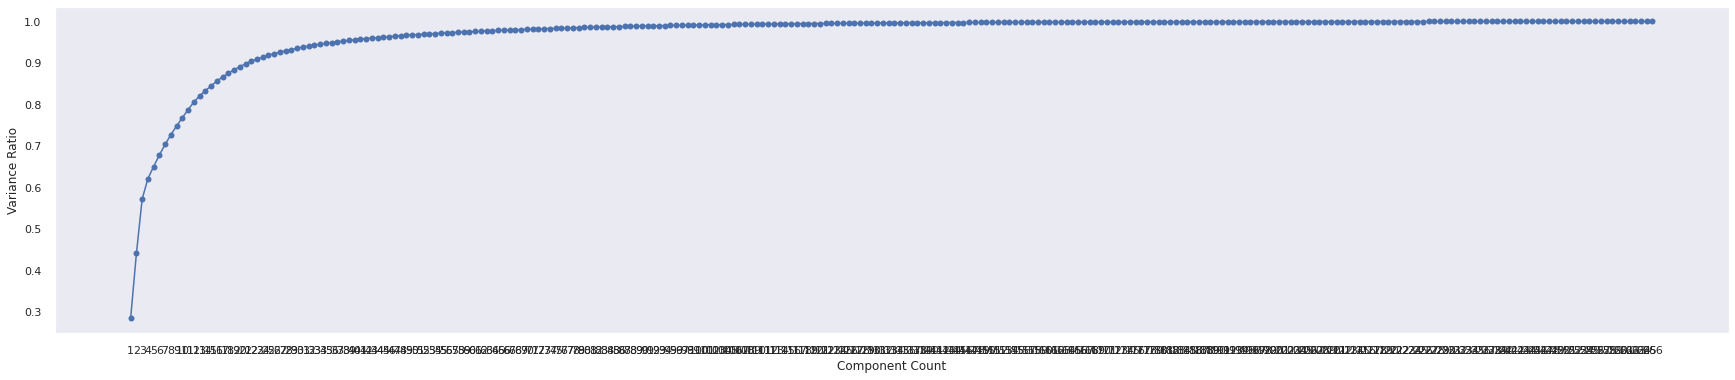

In [ ]:
plt.figure(figsize=(30,6))
pca = PCA().fit(df[V_columns])
x = range(1,len(V_columns)+1)
plt.plot(x,np.cumsum(pca.explained_variance_ratio_), "bo-")
plt.xlabel("Component Count")
plt.ylabel("Variance Ratio")
plt.xticks(range(1,df[V_columns].shape[1]+1))
plt.grid()
plt.show()

In [ ]:
pca = PCA(n_components = 29)
pca_V = pca.fit_transform(df[V_columns])
sum(pca.explained_variance_ratio_)

0.932310259447894

In [ ]:
np.cumsum(pca.explained_variance_ratio_)

array([0.28505188, 0.44054858, 0.57164736, 0.6209345 , 0.65013419,
       0.67809045, 0.70334164, 0.72710549, 0.74782796, 0.76796535,
       0.78728812, 0.80547777, 0.82053052, 0.83282917, 0.84472993,
       0.85631967, 0.86597899, 0.87508117, 0.88338873, 0.89090536,
       0.89795722, 0.90387678, 0.9092586 , 0.91409043, 0.91879048,
       0.92252516, 0.9260137 , 0.92925039, 0.93231026])

In [ ]:
gc.collect()

15466

In [ ]:
pca_V = pd.DataFrame(data = pca_V).add_prefix('pca_V')
df = df.join(pca_V)

df.drop(V_columns, axis=1, inplace=True)

### PCA for id Columns

In [ ]:
id_columns=[col for col in df.columns if re.search('^id\d*', col)]

In [ ]:
sc_id =  StandardScaler().fit(df[id_columns])
df[id_columns] = sc_id.transform(df[id_columns])

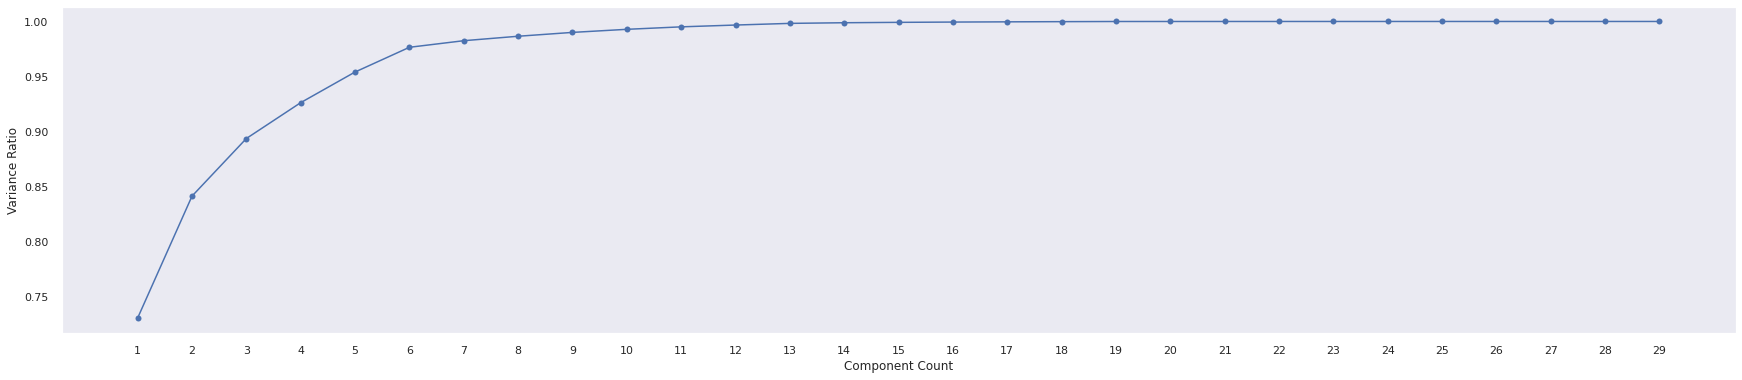

In [ ]:
plt.figure(figsize=(30,6))
pca = PCA().fit(df[id_columns])
x = range(1,len(id_columns)+1)
plt.plot(x,np.cumsum(pca.explained_variance_ratio_), "bo-")
plt.xlabel("Component Count")
plt.ylabel("Variance Ratio")
plt.xticks(range(1,df[id_columns].shape[1]+1))
plt.grid()
plt.show()

In [ ]:
pca = PCA(n_components = 6)
pca_id = pca.fit_transform(df[id_columns])
sum(pca.explained_variance_ratio_)

0.9765376349011594

In [ ]:
np.cumsum(pca.explained_variance_ratio_)

array([0.73062422, 0.84133981, 0.89367453, 0.92624723, 0.95407967,
       0.97653763])

In [ ]:
gc.collect()

3457

In [ ]:
pca_id = pd.DataFrame(data = pca_id).add_prefix('pca_id')
df = df.join(pca_id)

df.drop(id_columns, axis=1, inplace=True)

### PCA for M Columns

In [ ]:
M_columns = [col for col in df.columns if re.search('^M\d*', col)]
sc_M = StandardScaler().fit(df[M_columns])
df[M_columns] = sc_M.transform(df[M_columns])

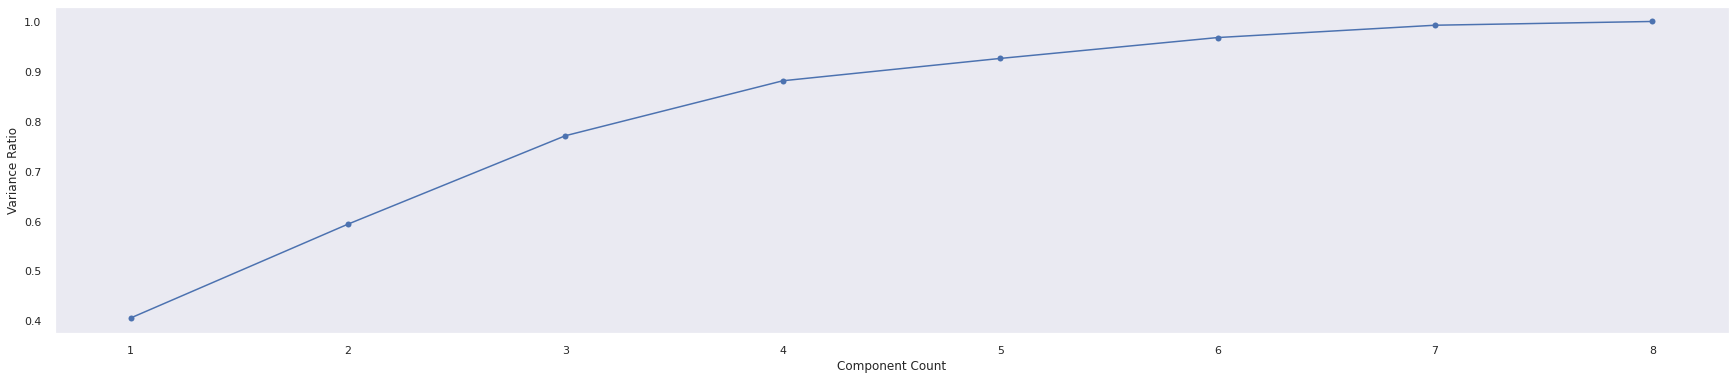

In [ ]:
plt.figure(figsize=(30,6))
pca = PCA().fit(df[M_columns])
x = range(1,len(M_columns)+1)
plt.plot(x,np.cumsum(pca.explained_variance_ratio_), "bo-")
plt.xlabel("Component Count")
plt.ylabel("Variance Ratio")
plt.xticks(range(1,df[M_columns].shape[1]+1))
plt.grid()
plt.show()

In [ ]:
pca = PCA(n_components = 5)
pca_M = pca.fit_transform(df[M_columns])
sum(pca.explained_variance_ratio_)

0.9259229464994408

In [ ]:
np.cumsum(pca.explained_variance_ratio_)

array([0.40563788, 0.5938102 , 0.77102459, 0.88114075, 0.92592295])

In [ ]:
gc.collect()

2460

In [ ]:
pca_M = pd.DataFrame(data = pca_M).add_prefix('pca_M')
df = df.join(pca_M)

df.drop(M_columns, axis=1, inplace=True)

### PCA for C Columns

In [ ]:
C_columns = [col for col in df.columns if re.search('^C\d*', col)]
sc_C = StandardScaler().fit(df[C_columns])
df[C_columns] = sc_C.transform(df[C_columns])

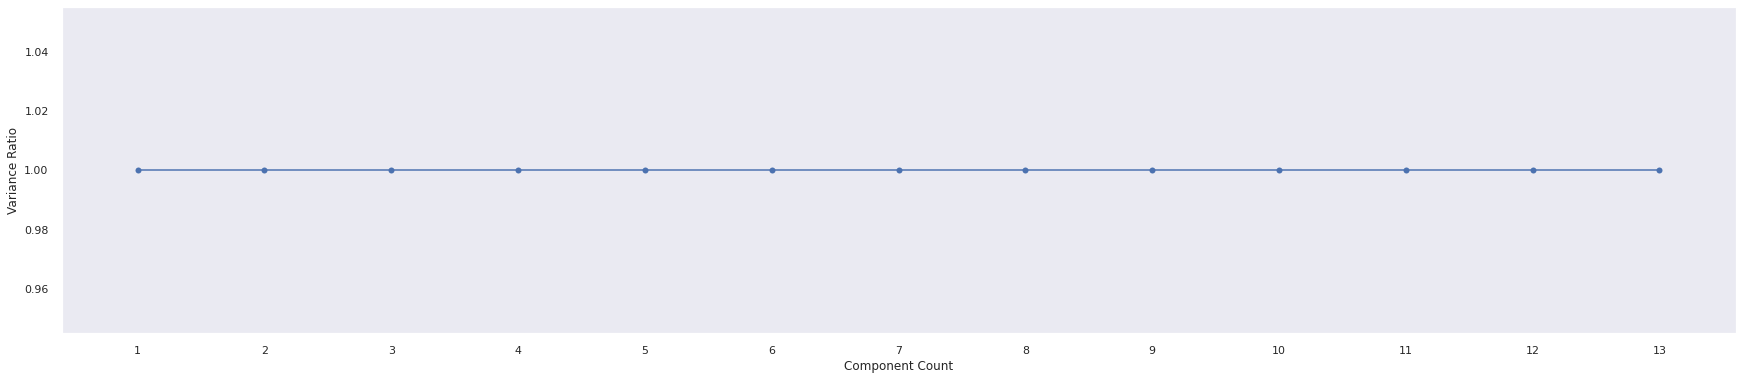

In [ ]:
plt.figure(figsize=(30,6))
pca = PCA().fit(df[C_columns])
x = range(1,len(C_columns)+1)
plt.plot(x,np.cumsum(pca.explained_variance_ratio_), "bo-")
plt.xlabel("Component Count")
plt.ylabel("Variance Ratio")
plt.xticks(range(1,df[C_columns].shape[1]+1))
plt.grid()
plt.show()

In [ ]:
pca = PCA(n_components = 2)
pca_C = pca.fit_transform(df[C_columns])
sum(pca.explained_variance_ratio_)

0.9999999999999989

In [ ]:
np.cumsum(pca.explained_variance_ratio_)

array([1., 1.])

In [ ]:
gc.collect()

2607

In [ ]:
pca_C = pd.DataFrame(data = pca_C).add_prefix('pca_C')
df = df.join(pca_C)

df.drop(C_columns, axis=1, inplace=True)

### PCA for D Columns

In [ ]:
D_columns = [col for col in df.columns if re.search('^D\d*', col)]
sc_D = StandardScaler().fit(df[D_columns])
df[D_columns] = sc_D.transform(df[D_columns])

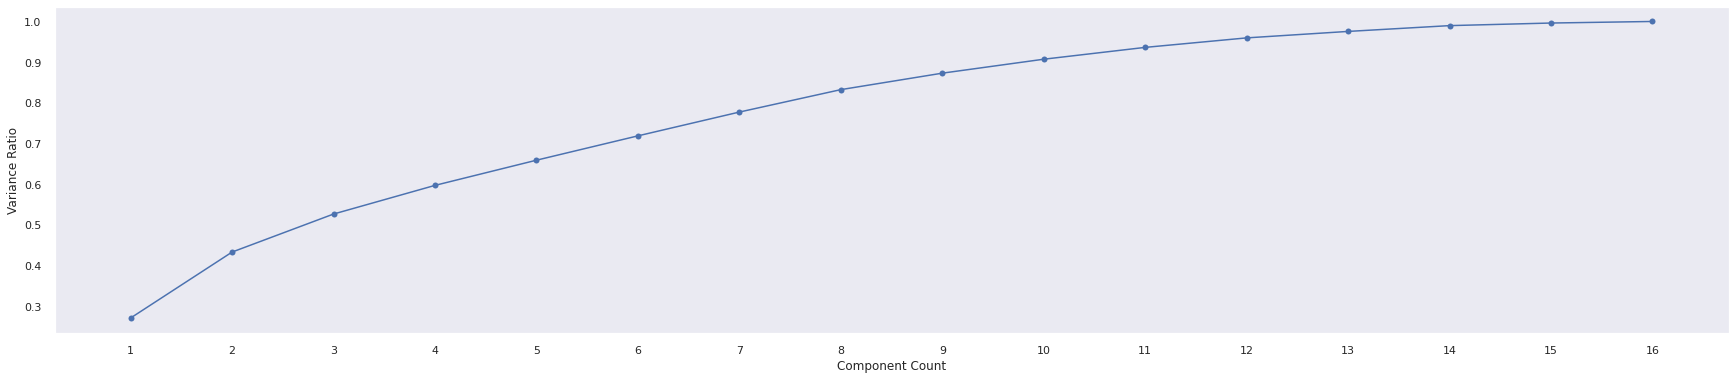

In [ ]:
plt.figure(figsize=(30,6))
pca = PCA().fit(df[D_columns])
x = range(1,len(D_columns)+1)
plt.plot(x,np.cumsum(pca.explained_variance_ratio_), "bo-")
plt.xlabel("Component Count")
plt.ylabel("Variance Ratio")
plt.xticks(range(1,df[D_columns].shape[1]+1))
plt.grid()
plt.show()

In [ ]:
pca = PCA(n_components = 11)
pca_D = pca.fit_transform(df[D_columns])
sum(pca.explained_variance_ratio_)

0.9362362440377197

In [ ]:
np.cumsum(pca.explained_variance_ratio_)

array([0.27049211, 0.43270359, 0.52624376, 0.59675406, 0.65869424,
       0.71856202, 0.77712732, 0.83229163, 0.87280571, 0.90712913,
       0.93623624])

In [ ]:
gc.collect()

2907

In [ ]:
pca_D = pd.DataFrame(data = pca_D).add_prefix('pca_D')
df = df.join(pca_D)

df.drop(D_columns, axis=1, inplace=True)

In [ ]:
df = reduce_mem_usage(df)
df.to_pickle('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/before_FE.pkl')

Memory usage of dataframe is 296.80 MB
Memory usage after optimization is: 80.54 MB
Decreased by 72.9%


### Feature Engineering

In [ ]:
data = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/train_dataset.pkl')
data = data.sort_values('TransactionDT').reset_index().drop('index', axis=1)

In [ ]:
df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/before_FE.pkl')

In [ ]:
# Numeric Features: TransactionAmt, id_02, D15, addr1
df[['id_02','D15','card4']] = data[['id_02','D15','card4']].copy()
df[['card4']] = df[['card4']].astype('object').fillna('None')
df[['id_02','D15']] = df[['id_02','D15']].fillna(df[['id_02','D15']].median())

df['TransactionAmt_to_mean_card1'] = df['TransactionAmt'] / df.groupby(['card1'])['TransactionAmt'].transform('mean')
df['TransactionAmt_to_mean_card4'] = df['TransactionAmt'] / df.groupby(['card4'])['TransactionAmt'].transform('mean')
df['TransactionAmt_to_std_card1'] = df['TransactionAmt'] / df.groupby(['card1'])['TransactionAmt'].transform('std')
df['TransactionAmt_to_std_card4'] = df['TransactionAmt'] / df.groupby(['card4'])['TransactionAmt'].transform('std')

df['id_02_to_mean_card1'] = df['id_02'] / df.groupby(['card1'])['id_02'].transform('mean')
df['id_02_to_mean_card4'] = df['id_02'] / df.groupby(['card4'])['id_02'].transform('mean')
df['id_02_to_std_card1'] = df['id_02'] / df.groupby(['card1'])['id_02'].transform('std')
df['id_02_to_std_card4'] = df['id_02'] / df.groupby(['card4'])['id_02'].transform('std')

df['D15_to_mean_card1'] = df['D15'] / df.groupby(['card1'])['D15'].transform('mean')
df['D15_to_mean_card4'] = df['D15'] / df.groupby(['card4'])['D15'].transform('mean')
df['D15_to_std_card1'] = df['D15'] / df.groupby(['card1'])['D15'].transform('std')
df['D15_to_std_card4'] = df['D15'] / df.groupby(['card4'])['D15'].transform('std')

df['D15_to_mean_addr1'] = df['D15'] / df.groupby(['addr1'])['D15'].transform('mean')
df['D15_to_std_addr1'] = df['D15'] / df.groupby(['addr1'])['D15'].transform('std')

# Decimal part of the transaction amount.
df['TransactionAmt_decimal'] = ((df['TransactionAmt'] - df['TransactionAmt'].astype(int)) * 1000).astype(int)

# Winsorized, log, sqrt and z_score version of transaction amount
# df['TransactionAmt_winsorize'] = pd.Series( winsorize(np.sqrt(df.TransactionAmt), limits=(0, 0.1)))
# df['TransactionAmt_log'] = df.TransactionAmt.apply(f_log)
# df['TransactionAmt_sqrt'] = df.TransactionAmt.apply(f_sqrt)
# df['TransactionAmt_z'] = zscore(df['TransactionAmt'])
gc.collect()
# df.head()

0

In [ ]:
df.drop(['id_02','D15','card4'], axis=1, inplace=True)

df.head()

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,dist1,Transaction_hour,Transaction_day_of_week,ProductCD_freq,R_emaildomain_1_freq,R_emaildomain_2_freq,R_emaildomain_3_freq,P_emaildomain_1_freq,P_emaildomain_2_freq,P_emaildomain_3_freq,card4_freq,card6_freq,pca_V0,pca_V1,pca_V2,pca_V3,pca_V4,pca_V5,pca_V6,pca_V7,pca_V8,pca_V9,pca_V10,pca_V11,pca_V12,pca_V13,pca_V14,pca_V15,pca_V16,pca_V17,pca_V18,pca_V19,pca_V20,...,pca_V28,pca_id0,pca_id1,pca_id2,pca_id3,pca_id4,pca_id5,pca_M0,pca_M1,pca_M2,pca_M3,pca_M4,pca_C0,pca_C1,pca_D0,pca_D1,pca_D2,pca_D3,pca_D4,pca_D5,pca_D6,pca_D7,pca_D8,pca_D9,pca_D10,TransactionAmt_to_mean_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card1,TransactionAmt_to_std_card4,id_02_to_mean_card1,id_02_to_mean_card4,id_02_to_std_card1,id_02_to_std_card4,D15_to_mean_card1,D15_to_mean_card4,D15_to_std_card1,D15_to_std_card4,D15_to_mean_addr1,D15_to_std_addr1,TransactionAmt_decimal
0,0,68.5,13926,-999.0,150.0,142.0,315.0,19.0,0.0,0.0,0.744629,0.767578,0.767578,0.995605,0.159912,0.160767,0.994629,0.011261,0.252197,-2.876953,-1.229492,-3.531250,0.520020,-1.750000,1.651367,-0.179688,-0.594238,1.037109,-4.226562,0.527344,0.520020,0.119751,1.914062,-0.402100,0.573242,-0.812012,0.046783,1.133789,0.113647,-0.131226,...,0.076660,-2.527344,-0.19397,-0.053558,-0.002243,0.006359,0.025955,-1.214844,1.988281,-0.889160,0.475098,0.005657,-0.208618,-0.0,-0.991699,-0.880371,0.671875,0.154541,0.255371,0.281982,-0.243164,0.113281,-0.152832,-0.128174,-0.084229,0.194580,0.257812,0.184560,0.170241,0.942877,1.036480,2.463995,1.778718,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,500
1,0,29.0,2755,404.0,150.0,102.0,325.0,8.0,0.0,0.0,0.744629,0.767578,0.767578,0.995605,0.387451,0.793457,0.994629,0.320312,0.252197,-2.619141,-0.373047,-0.206177,-0.803711,-2.085938,1.222656,0.335938,1.061523,-0.239990,3.175781,-0.519531,-1.480469,-0.557129,0.597656,-0.237549,0.792969,-0.423828,-0.157104,0.627930,0.245972,-0.050293,...,0.006229,-2.527344,-0.19397,-0.053558,-0.002243,0.006359,0.025955,-1.173828,1.115234,-0.508789,-0.340088,-0.848633,-0.268799,0.0,-1.057617,-0.923828,0.625488,0.240723,0.220703,0.235352,-0.217896,0.100464,-0.126465,-0.011185,-0.266602,0.123779,0.219116,0.063004,0.114214,0.980029,0.895980,2.184941,1.499293,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2,0,59.0,4663,490.0,150.0,166.0,330.0,287.0,0.0,0.0,0.744629,0.767578,0.767578,0.995605,0.009369,0.793457,0.994629,0.651367,0.745117,-4.617188,-0.228882,-1.342773,0.431152,1.110352,-1.536133,-0.338379,0.029968,0.111389,-0.076965,0.150879,0.024231,0.015060,2.136719,-0.923828,0.722656,0.094238,0.008995,0.615723,-0.028152,-0.330322,...,-0.070251,-2.527344,-0.19397,-0.053558,-0.002243,0.006359,0.025955,2.591797,0.100220,-1.340820,-0.247803,0.228149,-0.208618,0.0,0.243652,-0.823242,0.065796,0.611328,-0.172852,-0.438721,0.158813,0.095459,0.244019,1.259766,-1.048828,0.608398,0.443115,0.589226,0.258550,1.001403,0.921923,27.408990,1.610701,2.595703,2.080078,1.890892,1.631110,1.976562,1.627221,0
3,0,50.0,18132,567.0,150.0,117.0,476.0,8.0,0.0,0.0,0.744629,0.767578,0.767578,0.995605,0.174316,0.793457,0.994629,0.320312,0.745117,-3.376953,1.698242,-1.366211,-0.314941,-0.666016,2.162109,0.919434,-0.422852,-1.626953,3.589844,-0.957031,1.853516,-0.169312,-2.607422,-4.257812,1.832031,-0.361816,-0.548828,0.617188,0.667969,-0.846191,...,-0.351562,-2.527344,-0.19397,-0.053558,-0.002243,0.006359,0.025955,-0.746582,1.331055,-0.746582,-1.475586,-0.185181,-0.208618,-0.0,-0.170044,-0.778320,0.302490,0.511719,0.110718,0.176025,-0.175293,0.013557,-0.186646,-0.270264,0.073547,0.405029,0.377686,0.259460,0.196921,1.022073,0.895980,4.725647,1.499293,0.586426,0.783203,0.532817,0.586273,0.753418,0.605902,0
4,0,50.0,4497,514.0,150.0,102.0,420.0,8.0,0.0,0.0,0.055908,0.767578,0.767578,0.995605,0.387451,0.793457,0.994629,0.320312,0.252197,20.453125,-5.914062,-3.054688,-1.216797,-2.185547,-5.375000,11.992188,-0.307617,-1.404297,-0.939453,1.316406,-0.479492,-0.473145,-0.034576,-0.230

In [ ]:
# df.to_pickle('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/raw_data_phase8.pkl')

In [ ]:
gc.collect()

162

In [ ]:
df.shape

(590540, 87)

### Export Data

In [ ]:
# df = reduce_mem_usage_sd(df, verbose=True)
# # df.to_pickle('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/after_eda_phase8.pkl')
# # df= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/after_eda_phase8.pkl')
# gc.collect()

### Modeling with LightGBM

In [ ]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score

# for modeling 
import sklearn
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report, recall_score, f1_score
from sklearn.metrics import plot_precision_recall_curve, precision_recall_curve, plot_roc_curve, roc_curve, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import datasets, metrics
from sklearn.decomposition import PCA

# to avoid warnings
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")



warnings.simplefilter('ignore')
sns.set()
%matplotlib inline

In [ ]:
X = df.drop(['isFraud'], axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state =42)

In [ ]:
# LGBMClassifier with GPU

# clf = LGBMClassifier(
#           max_bin = 63,
#           num_leaves = 255,
#           num_iterations = 500,
#           learning_rate = 0.01,
#           tree_learner = 'serial',
#           task = 'df',
#           is_dfing_metric = False,
#           min_data_in_leaf = 1,
#           min_sum_hessian_in_leaf = 100,
#           sparse_threshold=1.0,
#           # device = 'gpu',
#           num_thread = -1,
#           save_binary= True,
#           seed= 42,
#           feature_fraction_seed = 42,
#           bagging_seed = 42,
#           drop_seed = 42,
#           data_random_seed = 42,
#           objective = 'binary',
#           boosting_type = 'gbdt',
#           verbose = 1,
#           metric = 'auc',
#           is_unbalance = True,
#           boost_from_average = False,
# )

clf = LGBMClassifier(
          num_leaves = 256,
          min_child_samples = 79,
          objective = 'binary',
          max_depth = 13,
          learning_rate = 0.03,
          boosting_type = "gbdt",
          subsample_freq = 3,
          subsample = 0.9,
          bagging_seed = 11,
          metric = 'auc',
          verbosity = -1,
          reg_alpha = 0.3,
          reg_lambda = 0.3,
          colsample_bytree = 0.9,
          is_unbalance = True,
)



In [ ]:
%time clf.fit(X_train, y_train)
# %time prints CPU Times and Wall Time

CPU times: user 1min 38s, sys: 337 ms, total: 1min 39s
Wall time: 51 s


LGBMClassifier(bagging_seed=11, boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.9, importance_type='split', is_unbalance=True,
               learning_rate=0.03, max_depth=13, metric='auc',
               min_child_samples=79, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=256, objective='binary',
               random_state=None, reg_alpha=0.3, reg_lambda=0.3, silent=True,
               subsample=0.9, subsample_for_bin=200000, subsample_freq=3,
               verbosity=-1)

In [ ]:
gc.collect()

253

### Feature Importance

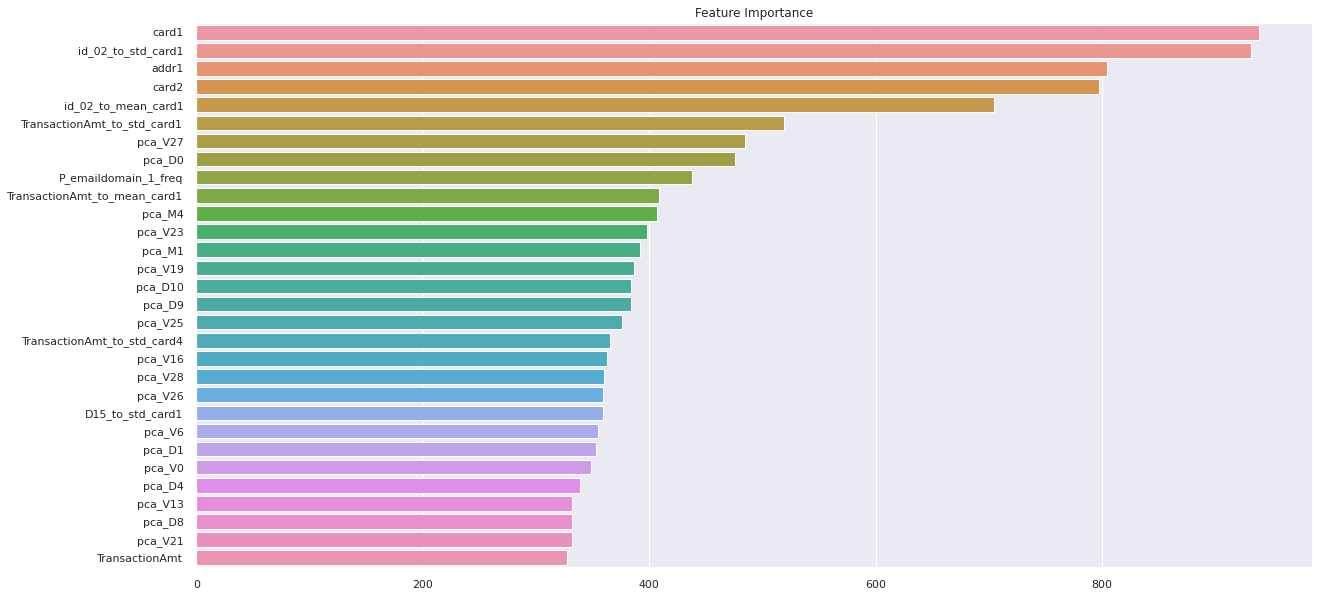

In [ ]:
plot_feature_importances(clf, 30)

### Model Evaluation

In [ ]:
y_pred = clf.predict(X_test)

              precision    recall  f1-score   support

           0       0.99      0.92      0.95    142469
           1       0.25      0.77      0.38      5166

    accuracy                           0.91    147635
   macro avg       0.62      0.85      0.67    147635
weighted avg       0.97      0.91      0.93    147635



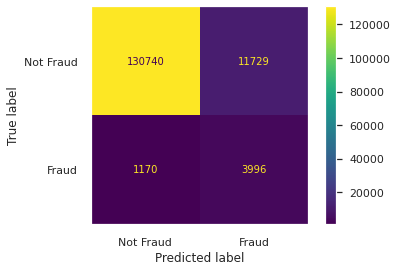

In [ ]:
plot_confusion_matrix(clf, X_test, y_test, values_format = '', 
                      display_labels=['Not Fraud', 'Fraud'])
plt.grid(None)
print(classification_report(y_test, y_pred, zero_division=0))

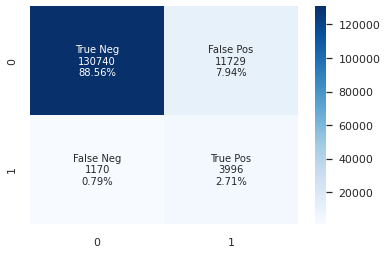

In [ ]:
# Alternative
group_names = ['True Neg','False Pos','False Neg','True Pos']
cf_matrix = confusion_matrix(y_test,y_pred)
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues');

              precision    recall  f1-score   support

           0       1.00      0.92      0.96    427408
           1       0.29      0.91      0.44     15497

    accuracy                           0.92    442905
   macro avg       0.65      0.91      0.70    442905
weighted avg       0.97      0.92      0.94    442905



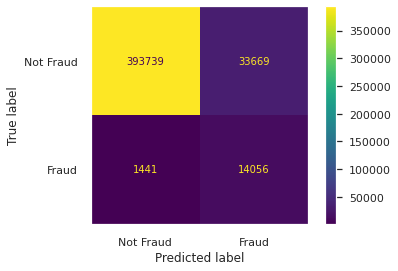

In [ ]:
y_train_pred = clf.predict(X_train)
plot_confusion_matrix(clf, X_train, y_train, values_format = '', 
                      display_labels=['Not Fraud', 'Fraud'])
plt.grid(None)
print(classification_report(y_train, y_train_pred, zero_division=0))

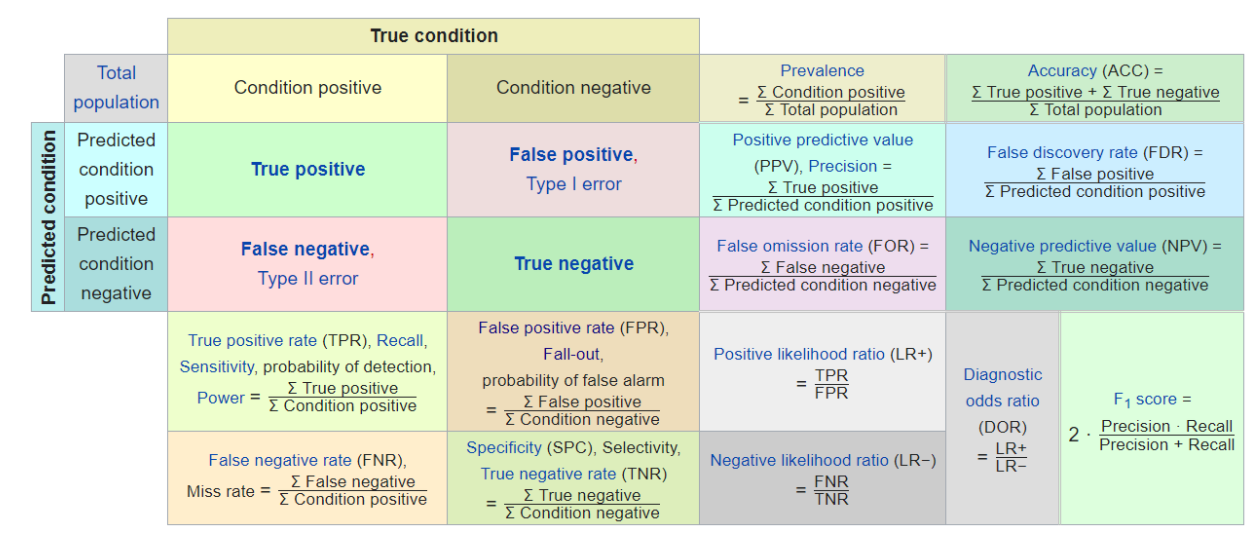

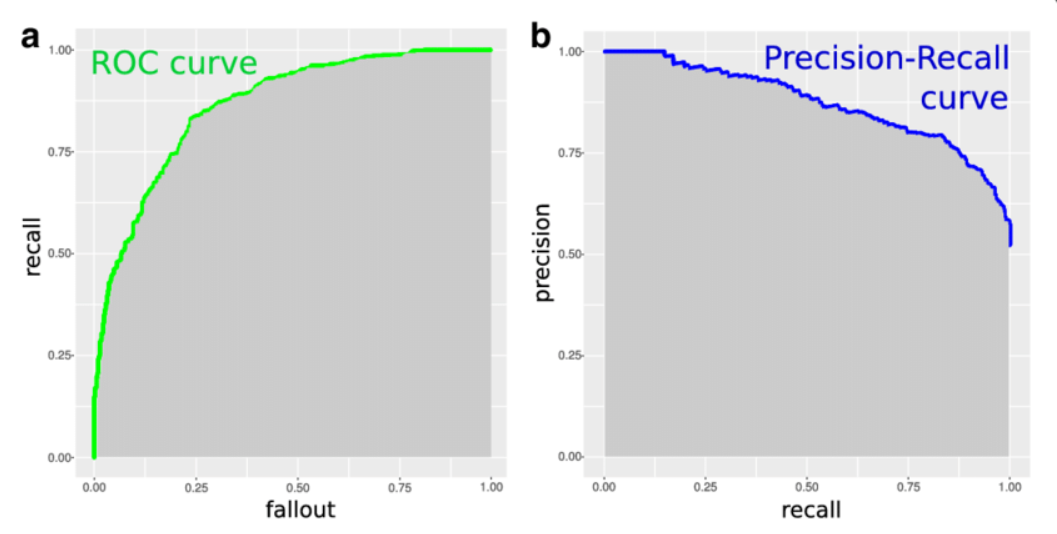

<Figure size 720x720 with 0 Axes>

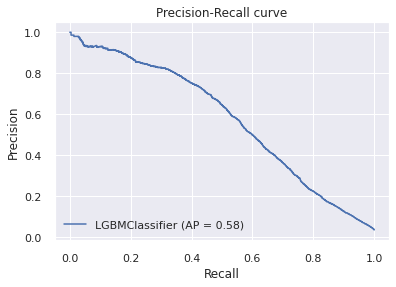

In [ ]:
from sklearn.metrics import plot_precision_recall_curve

plt.figure(figsize=(10,10))
disp = plot_precision_recall_curve(clf, X_test, y_test)
disp.ax_.set_title('Precision-Recall curve');

Test ROC AUC score: 0.9295582411775938
Train ROC AUC score: 0.9745024599056744


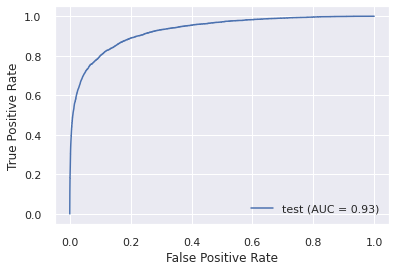

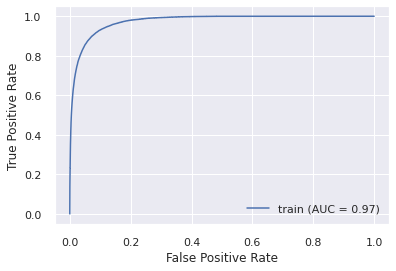

In [ ]:
plot_roc_curve(clf, X_test, y_test, name='test')
plot_roc_curve(clf, X_train, y_train, name='train')
print('Test ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print('Train ROC AUC score:', roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))

In [ ]:
from sklearn import metrics

clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)[:, 1]

auc = metrics.roc_auc_score(y_test, y_pred)

false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test, y_pred)

plt.figure(figsize=(8, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

Feature engineering yapmadan auc=0.9208

In [ ]:
# scores = cross_val_score(clf, X_train, y_train, cv=10)
# print('>> Mean CV score is: ', round(np.mean(scores),3))
# pltt = sns.distplot(pd.Series(scores,name='CV scores distribution'), color='r')

In [ ]:
# scores = cross_val_score(clf, X_test, y_test, cv=10)
# print('>> Mean CV score is: ', round(np.mean(scores),3))
# pltt = sns.distplot(pd.Series(scores,name='CV scores distribution'), color='r')